# Ex 12: The Spin Ellipsoid

Knowing that the spin kinetic energy is: 
$$E=\sum_{k=1}^3{\frac{1}{2}I_k\Omega_k^2}$$
It can be written as:
$$1=\sum_{k=1}^3{\frac{1}{2E}\frac{1}{I_k^{-1}}\Omega_k^2}$$
$$1=\sum_{k=1}^3{\frac{\Omega_k^2}{2\frac{E}{I_k}}}$$
This is an ellipsoid equation as $(\frac{x}{a})^2+(\frac{y}{b})^2+(\frac{z}{c})^2=1$. If the ellipse coefficient a, b and c are all equals to 1, therefore, the ellipse equation transform to $x^2+y^2+z^2=1$, which is the equation for a sphere of radius 1. In our case it would be:$\sqrt{2\frac{E}{I_x}}=\sqrt{2\frac{E}{I_y}}=\sqrt{2\frac{E}{I_z}}=1$. Which can also be written as $2\frac{E}{I_x}=2\frac{E}{I_y}=2\frac{E}{I_z}=1$

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

SCALE = 300
masslumps=np.array([[-1,4,1],
[0,3,1],
[0,-5,1],
[1,4,1],
[1,-2,1],
[-3,3,0],
[-3,1,0],
[-2,4,0],
[-2,2,0],
[-2,0,0],
[-2,-4,0],
[-1,5,0],
[-1,3,0],
[-1,1,0],
[-1,-1,0],
[-1,-3,0],
[-1,-5,0],
[-1,-7,0],
[0,6,0],
[0,4,0],
[0,2,0],
[0,0,0],
[0,-2,0],
[0,-4,0],
[0,-6,0],
[1,5,0],
[1,3,0],
[1,1,0],
[1,-1,0],
[1,-3,0],
[1,-5,0],
[2,4,0],
[2,2,0],
[2,0,0],
[2,-2,0],
[3,1,0],
[-2,2,-1],
[-1,5,-1],
[-1,3,-1],
[-1,1,-1],
[-1,-5,-1],
[0,6,-1],
[0,4,-1],
[0,2,-1],
[0,0,-1],
[0,2,-1],
[0,4,-1],
[0,6,-1],
[1,5,-1],
[1,3,-1],
[1,1,-1],
[1,-3,-1],
[1,-5,-1],
[2,4,-1]])

center_of_mass = np.mean(masslumps, axis=0)*SCALE
points_remap = masslumps*SCALE - center_of_mass
total_mass = 5e13 # Total mass of the system (in kg)
mass_per_point = total_mass / len(masslumps)

def inertia_moment(mass, x, y):
    return mass * (x**2 + y**2)
def inertia_product(mass, x, y):
    return mass * x * y

inertia = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]], dtype=float)

m = mass_per_point
for [x, y, z] in points_remap:
    inertia += np.array([[inertia_moment(m, y, z), -inertia_product(m, x, y), -inertia_product(m, x, z)],
                         [-inertia_product(m, x, y), inertia_moment(m, x, z), -inertia_product(m, y, z)],
                         [-inertia_product(m, x, z), -inertia_product(m, y, z), inertia_moment(m, x, y)]])

w,_=np.linalg.eig(inertia)
w

array([9.26067960e+18, 5.73866005e+19, 6.34453125e+19])

To draw the spin energy ellipsoid representing the possible values of rotation velocities for a specific energy, we need to fix an energy. Then, to simulate trajectories that also lives on that shape, it will be required to evaluate that ellipsis to have the starting coordinates for the solver, in that way, it ensures that the trajectory will correspond to the right energy.

Max Accuracy (worst) =  0.0005%


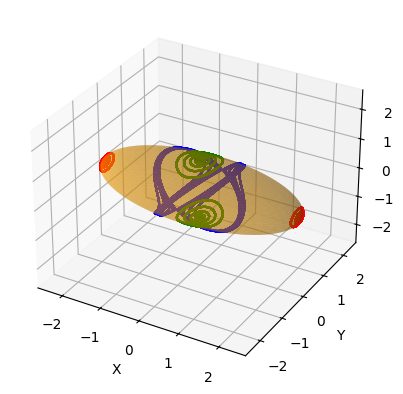

In [111]:
target_energy = 3e19
principal_intertia = np.array(w)

# Define the system of differential equations
def eulereqns(t, angvel):
    return (-np.subtract(*principal_intertia[2:0:-1]) * np.multiply(*angvel[1:]) / principal_intertia[0],
            -np.subtract(*principal_intertia[::2]) * np.multiply(*angvel[::-2]) / principal_intertia[1],
            -np.subtract(*principal_intertia[1::-1]) * np.multiply(*angvel[:2]) / principal_intertia[2])

# Define the coefficients of the ellipsoid
rx, ry, rz =np.sqrt(2*target_energy/principal_intertia)
# Define the 3 central angles of the ellipsoid (one for each axis) [x, y, z]
uv = [(0, np.pi/2, 'red'), (np.pi/2, np.pi/2, 'blue'), (0, 0, 'green'),
      (np.pi, np.pi/2, 'red'), (3*np.pi/2, np.pi/2, 'blue'), (0, np.pi, 'green')]
tfinal = 100
number_of_trajectories = 6

angvels = []
for u, v, color in uv:
    # Then we add a small variation to the central angles to see multiple trajectories around that central point
    for var in np.linspace(0, np.pi/24, number_of_trajectories):
        v += var/2
        u += var/2
        x = rx * np.cos(u) * np.sin(v)
        y = ry * np.sin(u) * np.sin(v)
        z = rz * np.cos(v)
        angvel0 = np.array([x, y, z])
        inenergy = 0.5 * np.sum(principal_intertia * angvel0 ** 2)
        t = np.linspace(0, tfinal, 10000)
        angvel = odeint(eulereqns, angvel0, t, tfirst=True)
        tend = len(angvel) - 1
        finenergy = 0.5 * np.sum(principal_intertia * angvel[tend] ** 2)
        accuracy = abs((finenergy - inenergy) / inenergy)
        angvels.append((accuracy, t, angvel, color))

print(f'Max Accuracy (worst) = {max([acc for acc, _, _, _ in angvels]): .4%}')

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot_surface(x, y, z, color='orange', alpha=0.4)
for _, _, angvel, color in angvels:
    ax.plot(angvel[:, 0], angvel[:, 1], angvel[:, 2], color=color) # Draw the trajectories

# Adjustment of the axes, so that they all have the same span:
max_radius = max(rx, ry, rz)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

plt.show()

From the previous digram, it is clear that the most stable axis is the X axis and the less stable axis is the Y axis. Even really small rotation velocity around this axis will end up on high amplitude motion.

## Period of motion

Period of motion: 2.9202920292029204


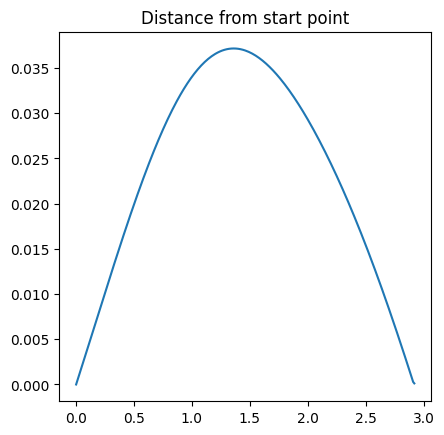

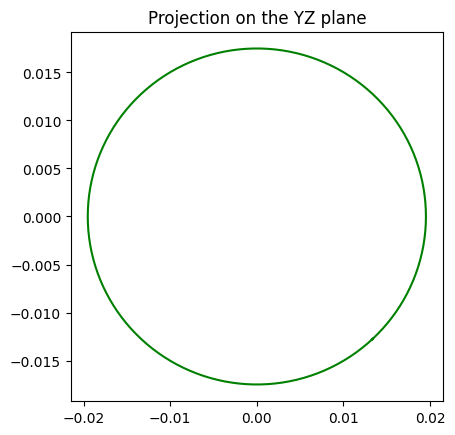

In [112]:
from scipy.signal import argrelextrema
from numpy import less
_, t, av, _ = angvels[1]
distance_from_start = np.sqrt((av[:, 0]-av[0, 0])**2 + (av[:, 1]-av[0, 1])**2 + (av[:, 2]-av[0, 2])**2)
idx = argrelextrema(distance_from_start, less)
first_loop = idx[0][0]
print(f"Period of motion: {t[first_loop]}") # Period of motion in seconds

plt.figure(figsize=plt.figaspect(1))  # Square figure
plt.title('Distance from start point')
plt.plot(t[:first_loop+1], distance_from_start[:first_loop+1])
plt.show()
plt.figure(figsize=plt.figaspect(1))  # Square figure
plt.title('Projection on the YZ plane')
plt.plot(av[:first_loop+1, 1], av[:first_loop+1, 2], color=color) # Draw the trajectories
plt.show()

In [113]:
# Farther from the center point
_, t, av, _ = angvels[5]
distance_from_start = np.sqrt((av[:, 0]-av[0, 0])**2 + (av[:, 1]-av[0, 1])**2 + (av[:, 2]-av[0, 2])**2)
idx = argrelextrema(distance_from_start, less)
first_loop = idx[0][0]
print(f"Period of motion: {t[first_loop]}") # Period of motion in seconds

Period of motion: 3.0303030303030303


Here is the period of motion when relatively close to the center point of motion along the X axis. As we repeat this calculation farther from the axis, the period increase. This can be repeated for the other stable axis Z. 

Period of motion: 8.22082208220822


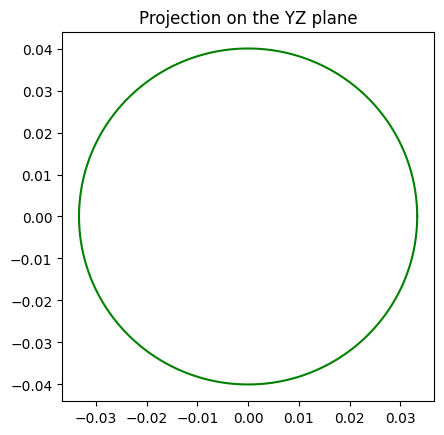

In [114]:
_, t, av, _ = angvels[number_of_trajectories*2+1]
distance_from_start = np.sqrt((av[:, 0]-av[0, 0])**2 + (av[:, 1]-av[0, 1])**2 + (av[:, 2]-av[0, 2])**2)
idx = argrelextrema(distance_from_start, less)
first_loop = idx[0][0]
print(f"Period of motion: {t[first_loop]}") # Period of motion in seconds

plt.figure(figsize=plt.figaspect(1))  # Square figure
plt.title('Projection on the YZ plane')
plt.plot(av[:first_loop+1, 0], av[:first_loop+1, 1], color=color) # Draw the trajectories
plt.show()

The period of motion for the Y axis is much greater than the X axis. This is due to the shape being more flat on that axis meaning that the distance is greater to travel for the oscillator.

## Euler’s equations period

Assuming the following Euler's equation:

$$
\frac{d\Omega_x}{dt}+\frac{I_z-I_y}{I_x}\Omega_y\Omega_z=0
$$
$$
\frac{d\Omega_y}{dt}+\frac{I_x-I_z}{I_y}\Omega_x\Omega_z=0
$$
$$
\frac{d\Omega_z}{dt}+\frac{I_y-I_x}{I_z}\Omega_y\Omega_x=0
$$

It is possible to derive the period of motion from these.

### Axis X

For a motion closer as possible from this axis. It can be assumed that $\frac{\Omega_x}{dt}=0$. From that we differentiate the equations for Y and Z axis.

$$
\begin{cases}
\frac{d^2\Omega_y}{dt^2}+\frac{I_x-I_z}{I_y}\Omega_x\frac{d\Omega_z}{dt}=0\\
\frac{d^2\Omega_z}{dt^2}+\frac{I_y-I_x}{I_z}\Omega_x\frac{d\Omega_y}{dt}=0
\end{cases}
$$
$$
\begin{cases}
\frac{d^2\Omega_y}{dt^2}-\frac{I_x-I_z}{I_y}\Omega_x^2\frac{I_y-I_x}{I_z}\Omega_y=0\\
\frac{d^2\Omega_z}{dt^2}-\frac{I_y-I_x}{I_z}\Omega_x^2\frac{I_x-I_z}{I_y}\Omega_z=0
\end{cases}
$$

Now, this is clear that $\Omega_y$ and $\Omega_z$ follow a harmonic oscillator equation of type $\frac{d^2x}{dt^2}+\frac{k}{m}x=0$. Then, the period can be defined as $T=\frac{2\pi}{\sqrt{\frac{k}{m}}}$.

In this case, $\frac{k}{m}=-\frac{(I_y-I_x)(I_x-I_z)}{I_yI_z}\Omega_x^2$. Hence,

$$T=\frac{2\pi}{\sqrt{-\frac{(I_y-I_x)(I_x-I_z)}{I_yI_z}\Omega_x^2}}$$

In [115]:
x0 = rx
km = -x0**2/(w[1]*w[2])*(w[0]-w[2])*(w[1]-w[0])
period = 2*np.pi/np.sqrt(km)
print(period) # Period of motion in seconds

2.916776136151734


As expected the period is really close to the period previously calculate with the simulated motion.

### Axis Z

Now, we are doing the same calculation with the Z axis. In this case, it can be assumed that $\frac{\Omega_z}{dt}=0$. From that, we differentiate the equations for X and Y axis.

$$
\begin{cases}
\frac{d^2\Omega_x}{dt^2}+\frac{I_z-I_y}{I_x}\Omega_z\frac{d\Omega_y}{dt}=0\\
\frac{d^2\Omega_y}{dt^2}+\frac{I_x-I_z}{I_y}\Omega_z\frac{d\Omega_x}{dt}=0
\end{cases}
$$
$$
\begin{cases}
\frac{d^2\Omega_x}{dt^2}-\frac{I_z-I_y}{I_x}\Omega_z^2\frac{I_x-I_z}{I_y}\Omega_x=0\\
\frac{d^2\Omega_y}{dt^2}+\frac{I_x-I_z}{I_y}\Omega_z^2\frac{I_z-I_y}{I_x}\Omega_y=0
\end{cases}
$$

Now, this is clear that $\Omega_y$ and $\Omega_z$ follow a harmonic oscillator equation of type $\frac{d^2x}{dt^2}+\frac{k}{m}x=0$. Then, the period can be defined as $T=\frac{2\pi}{\sqrt{\frac{k}{m}}}$.

In this case, $\frac{k}{m}=-\frac{(I_x-I_z)(I_z-I_y)}{I_yI_x}\Omega_z^2$. Hence,

$$T=\frac{2\pi}{\sqrt{-\frac{(I_x-I_z)(I_z-I_y)}{I_yI_x}\Omega_z^2}}$$

In [116]:
z0 = rz
km = -z0**2/(w[1]*w[0])*(w[0]-w[2])*(w[2]-w[1])
period = 2*np.pi/np.sqrt(km)
print(period) # Period of motion in seconds

8.22058023422136


Finally, for the Z axis the results are also similar to what we should expect.